In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
%load_ext line_profiler
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)

In [2]:
from merf.utils import MERFDataGenerator
from merf.merf import MERF

# Test Data Generation

In [64]:
dgm = MERFDataGenerator(m=.6, sigma_b=np.sqrt(4.5), sigma_e=1)

In [65]:
num_clusters_each_size = 20
train_sizes = [1, 3, 5, 7, 9]
known_sizes = [9, 27, 45, 63, 81]
new_sizes = [10, 30, 50, 70, 90]

In [66]:
# Smaller set that can be used for debugging
# num_clusters_each_size = 1
# train_sizes = [1, 3]
# known_sizes = [9, 27]
# new_sizes = [10, 30]

In [67]:
train_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(train_sizes, num_clusters_each_size)
known_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(known_sizes, num_clusters_each_size)
new_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(new_sizes, num_clusters_each_size)

In [68]:
len(train_cluster_sizes), len(known_cluster_sizes), len(new_cluster_sizes)

(100, 100, 100)

In [69]:
train, test_known, test_new, training_cluster_ids, ptev, prev = dgm.generate_split_samples(train_cluster_sizes, known_cluster_sizes, new_cluster_sizes)

INFO     [utils.py:164] Drew 10000 samples from 200 clusters.
INFO     [utils.py:165] PTEV = 89.92306530779202, PREV = 50.42778063639541.


In [70]:
len(train), len(test_known), len(test_new)

(500, 4500, 5000)

In [71]:
train.head()

,y,X_0,X_1,X_2,Z,cluster
0,-0.132555,-0.070097,-0.169975,0.431369,1.0,0
10,7.367295,2.371786,0.185957,1.003058,1.0,1
20,1.730853,1.073621,-1.120714,-1.233593,1.0,2
30,8.191993,0.124075,-2.007312,-2.160508,1.0,3
40,3.555436,0.977662,0.632112,0.036175,1.0,4


# MERF Training

In [72]:
X_train = train[['X_0', 'X_1', 'X_2']]
Z_train = train[['Z']]
clusters_train = train['cluster']
y_train = train['y']

In [73]:
mrf = MERF(n_estimators=300, max_iterations=100)
mrf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf.py:235] GLL is 1055.7566897458835 at iteration 1.
INFO     [merf.py:235] GLL is 916.1102271283887 at iteration 2.
INFO     [merf.py:235] GLL is 890.7044224125543 at iteration 3.
INFO     [merf.py:235] GLL is 884.5789365008372 at iteration 4.
INFO     [merf.py:235] GLL is 889.3014079521929 at iteration 5.
INFO     [merf.py:235] GLL is 889.1383695812408 at iteration 6.
INFO     [merf.py:235] GLL is 882.5890305065777 at iteration 7.
INFO     [merf.py:235] GLL is 892.576122580085 at iteration 8.
INFO     [merf.py:235] GLL is 879.1580330677486 at iteration 9.
INFO     [merf.py:235] GLL is 879.7631674067123 at iteration 10.
INFO     [merf.py:235] GLL is 895.7692746919284 at iteration 11.
INFO     [merf.py:235] GLL is 904.1329197713377 at iteration 12.
INFO     [merf.py:235] GLL is 884.4448869238723 at iteration 13.
INFO     [merf.py:235] GLL is 890.9760755201743 at iteration 14.
INFO     [merf.py:235] GLL is 896.9345245866348 at iteration 15.
INFO     [merf.py:235] GLL is 879.

Text(0.5,0,'Iteration')

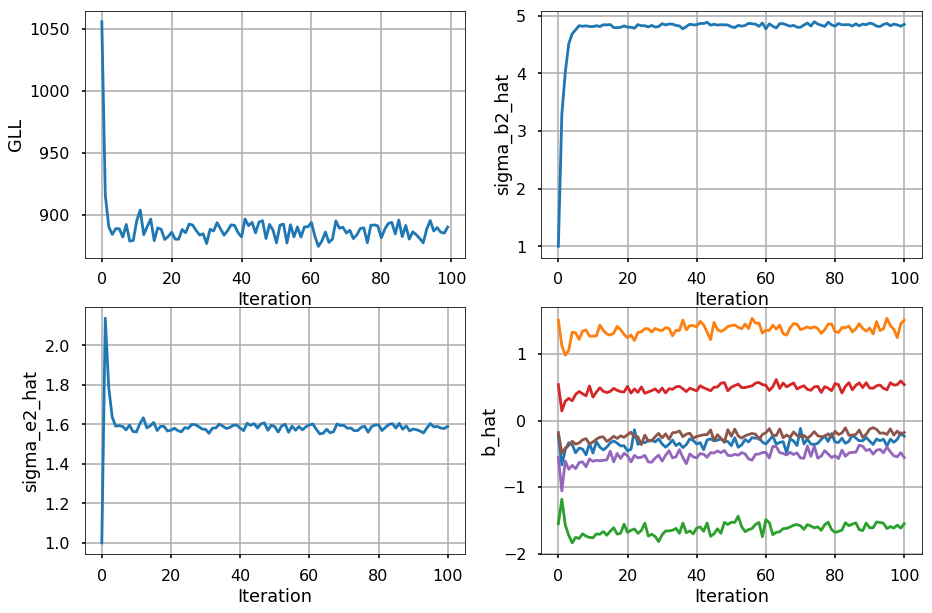

In [74]:
plt.figure(figsize=[15,10])
plt.subplot(221)
plt.plot(mrf.gll_history)
plt.grid('on')
plt.ylabel('GLL')
plt.xlabel('Iteration')

plt.subplot(222)
D_hat_history = [x[0][0] for x in mrf.D_hat_history]
plt.plot(D_hat_history)
plt.grid('on')
plt.ylabel('sigma_b2_hat')
plt.xlabel('Iteration')

plt.subplot(223)
plt.plot(mrf.sigma2_hat_history)
plt.grid('on')
plt.ylabel('sigma_e2_hat')
plt.xlabel('Iteration')

plt.subplot(224)
b_df = pd.concat(mrf.b_hat_history, axis=1)
b_df.columns = range(0, 101)
plt.plot(b_df.loc[0])
plt.plot(b_df.loc[20])
plt.plot(b_df.loc[30])
plt.plot(b_df.loc[40])
plt.plot(b_df.loc[50])
plt.plot(b_df.loc[60])
plt.grid('on')
plt.ylabel('b_hat')
plt.xlabel('Iteration')

Text(0.5,1,'Distribution of b_is')

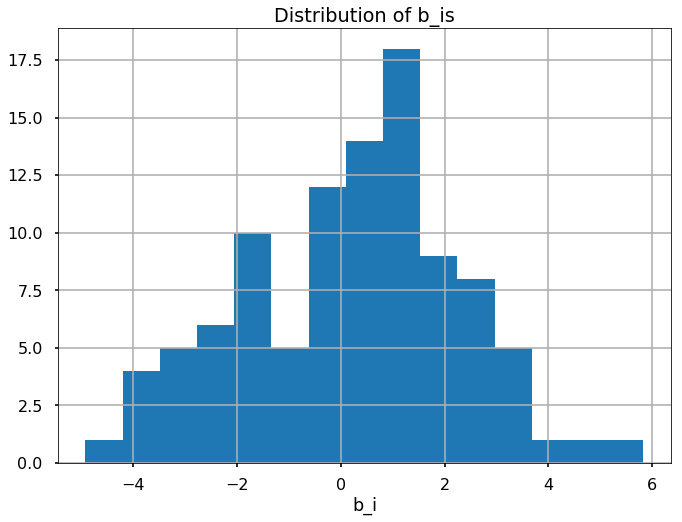

In [75]:
mrf.trained_b.hist(bins=15)
plt.xlabel('b_i')
plt.title('Distribution of b_is')

# MERF Prediction

In [99]:
X_known = test_known[['X_0', 'X_1', 'X_2']]
Z_known = test_known[['Z']]
clusters_known = test_known['cluster']
y_known = test_known['y']

In [100]:
assert len(y_hat_known) == len(y_known)

In [101]:
X_new = test_new[['X_0', 'X_1', 'X_2']]
Z_new = test_new[['Z']]
clusters_new = test_new['cluster']
y_new = test_new['y']

In [102]:
y_hat_known = mrf.predict(X_known, Z_known, clusters_known)
y_hat_known

array([ 6.57673186, -1.43042298,  4.01878245, ...,  4.70579036,
        2.67607293,  0.28441851])

In [103]:
y_hat_new = mrf.predict(X_new, Z_new, clusters_new)
y_hat_new

array([ 4.54853784,  2.67002571,  1.2784949 , ...,  0.33731191,
        3.15116351,  1.44227498])

In [104]:
assert len(y_hat_new) == len(y_new)

# MERF vs. Random Forest on Fixed Effects

In [ ]:
mrf.

In [73]:
# Train and test using classic random forest. 
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [74]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [75]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [76]:
y_hat_known_rf = rf.predict(X_known)

In [77]:
pmse_known_rf = np.mean((y_known - y_hat_known_rf) ** 2)
pmse_known_rf

6.1108047838575983

In [78]:
y_hat_known_merf = mrf.predict(X_known, Z_known, clusters_known)

In [79]:
pmse_known_merf = np.mean((y_known - y_hat_known_merf) ** 2)
pmse_known_merf

2.1615926011237274

In [80]:
rd_known = 100 * (pmse_known_rf - pmse_known_merf) / pmse_known_rf
rd_known

64.626711577600616

In [81]:
y_hat_new_rf = rf.predict(X_new)

In [82]:
pmse_new_rf = np.mean((y_new - y_hat_new_rf) ** 2)
pmse_new_rf

7.5871359870667101

In [83]:
y_hat_new_merf = mrf.predict(X_new, Z_new, clusters_new)

In [84]:
pmse_new_merf = np.mean((y_new - y_hat_new_merf) ** 2)
pmse_new_merf

8.7643625665834453

In [85]:
rd_new = 100 * (pmse_new_rf - pmse_new_merf) / pmse_new_rf
rd_new

-15.516086459020578

# MERF vs Random Forest with OHE Cluster Ids

In [105]:
rf_ohe = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [106]:
categories = np.sort(clusters_train.unique())

In [108]:
clusters_train_prime = clusters_train.astype('category', categories=categories)

In [109]:
X_ohe = pd.get_dummies(clusters_train_prime, prefix='cluster')

In [110]:
X_ohe.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_90,cluster_91,cluster_92,cluster_93,cluster_94,cluster_95,cluster_96,cluster_97,cluster_98,cluster_99
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
X_train_ohe = pd.merge(X_train, X_ohe, left_index=True, right_index=True)

In [112]:
rf_ohe.fit(X_train_ohe, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [113]:
clusters_known_prime = clusters_known.astype('category', categories=categories)

In [114]:
X_known_ohe = pd.get_dummies(clusters_known_prime, prefix='cluster')

In [115]:
X_known_ohe.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_90,cluster_91,cluster_92,cluster_93,cluster_94,cluster_95,cluster_96,cluster_97,cluster_98,cluster_99
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
X_known_w_ohe = pd.merge(X_known, X_known_ohe, left_index=True, right_index=True)

In [117]:
y_hat_known_rf_ohe = rf_ohe.predict(X_known_w_ohe)

In [118]:
mse_known_rf_ohe = np.mean((y_known - y_hat_known_rf_ohe) ** 2)
mse_known_rf_ohe

5.4868954844489002

In [119]:
clusters_new_prime = clusters_new.astype('category', categories=categories)

/Users/souravdey/.virtualenvs/merf/lib/python3.6/site-packages/pandas/core/internals.py:490: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))


In [120]:
X_new_ohe = pd.get_dummies(clusters_new_prime, prefix='cluster')

In [121]:
X_new_ohe.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_90,cluster_91,cluster_92,cluster_93,cluster_94,cluster_95,cluster_96,cluster_97,cluster_98,cluster_99
5000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
X_new_w_ohe = pd.merge(X_new, X_new_ohe, left_index=True, right_index=True)

In [123]:
y_hat_new_rf_ohe = rf_ohe.predict(X_new_w_ohe)

In [124]:
mse_new_rf_ohe = np.mean((y_new - y_hat_new_rf_ohe) ** 2)
mse_new_rf_ohe

6.3309646740350836